# 고객 생애 가치 분석 프로젝트

고객 생애 가치(CLV).  
사업상 고객 한 명에게 합리적으로 기대할 수 있는 총 수익을 나타내는 지표  
  .  

고객 생애 가치 계산법  


1. 평균 구매 가치 : 일정 기간의 총 매출을 같은 기간에 발생한 구매 횟수로 나누어 고객수만큼 더한 후 평균
2. 평균 구매 빈도율 : 일정 기간의 구매 횟수를 구매 고객 수로 나누어 계산
3. 고객가치 : 평균 구매 가치에 평균 구매 빈도율을 곱함
4. 평균 고객 수명 : 고객이 회사에서 지속해서 구매한 기간의 평균
5. 고객 생애 가치 : 고객가치와 평균 고객 수명을 곱함


### 데이터 불러오기 및 전처리


In [2]:
### 데이터 불러오기
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

closed_deals_url = '/content/drive/MyDrive/Colab Notebooks/코트스테이츠 프로젝트/CP2/olist_closed_deals_dataset.csv'
marketing_url = '/content/drive/MyDrive/Colab Notebooks/코트스테이츠 프로젝트/CP2/olist_marketing_qualified_leads_dataset.csv'
order_items_url = '/content/drive/MyDrive/Colab Notebooks/코트스테이츠 프로젝트/CP2/olist_order_items_dataset.csv'
sellers_url = '/content/drive/MyDrive/Colab Notebooks/코트스테이츠 프로젝트/CP2/olist_sellers_dataset.csv'

closed_deals = pd.read_csv(closed_deals_url)
marketing = pd.read_csv(marketing_url)
order_items = pd.read_csv(order_items_url)
sellers = pd.read_csv(sellers_url)

In [40]:
class customer_lifetime_value() : 
    def __init__(self, m, c, o, s) :
        self.m = marketing
        self.c = closed_deals
        self.o = order_items
        self.s = sellers
        self.df_marketing, self.df_clv, self.df_clv_ = self.make_marketing_df()
        self.marketing_month = self.df_marketing['first_contact_month'].unique().tolist()
        self.clv_month = sorted(self.df_clv['shipping_limit_month'].unique().tolist())
        self.clv_month = [m for m in self.clv_month if m not in self.marketing_month]
        self.recent_marketing_budget = self.cal_marketing_budget(s_date=self.marketing_month[-2], e_date=self.clv_month[0])

    # 데이터 전처리를 진행하는 함수
    def make_marketing_df(self) : 
        df_a = self.m
        df_b = self.c
        df_c = self.o

        # 마케팅 채널 분석을 위한 데이터 프레임 생성
        df_a['origin'] = df_a['origin'].fillna('unknown')
        df_marketing = pd.merge(df_b, df_a, on = 'mql_id', how = 'right')
        df_marketing['won_date'] = df_marketing['won_date'].fillna('2022-12-31 00:00:00')
        # 거래 성사일까지 걸리는 일을 구하는 함수
        def convert_date(x) :
            x = int(str(x)[:-14])
            if x > 1000 : 
                return -100
            else : 
                return x
        df_marketing['won_date'] = pd.to_datetime(df_marketing['won_date'])
        df_marketing['first_contact_date'] = pd.to_datetime(df_marketing['first_contact_date'])
        df_marketing['transaction_date'] = (df_marketing['won_date'] - df_marketing['first_contact_date'])
        df_marketing['transaction_date'] = df_marketing['transaction_date'].apply(lambda x : convert_date(x))
        df_marketing.sort_values(by = 'first_contact_date', inplace = True)
        df_marketing = df_marketing.reset_index(drop = True)
        df_marketing['first_contact_month'] = df_marketing['first_contact_date'].dt.strftime('%Y-%m')
        df_marketing['first_contact_year'] = df_marketing['first_contact_date'].dt.strftime('%Y')

        # 고객 생애 가치 분석을 위한 데이터 프레임 생성
        df_c['shipping_limit_date'] = df_c['shipping_limit_date'].apply(lambda x : x[:10])
        df_clv_ = df_c.groupby(['seller_id', 'shipping_limit_date']).agg({'price' : 'sum'})
        df_clv_ = pd.DataFrame(df_clv_).reset_index()
        df_clv_['sales'] = df_clv_['price'].apply(lambda x : round(x * 0.08, 3))
        df_clv = pd.merge(df_marketing, df_clv_, on = 'seller_id', how = 'left')
        df_clv = df_clv[df_clv['seller_id'].isnull() == False]
        df_clv['won_date'] = df_clv['won_date'].apply(lambda x : str(x)[:7])
        df_clv = df_clv[['mql_id', 'seller_id', 'won_date', 'business_segment', 
                        'business_type', 'landing_page_id', 'origin', 'transaction_date', 
                        'first_contact_month', 'shipping_limit_date', 'sales']]
        df_clv['business_type'] = df_clv['business_type'].fillna('unknown')
        df_clv['shipping_limit_date'] = df_clv['shipping_limit_date'].fillna('2022-12-31')
        df_clv['shipping_limit_month'] = df_clv['shipping_limit_date'].apply(lambda x : x[:7])
        df_clv['sales'] = df_clv['sales'].fillna(0)
        return df_marketing, df_clv, df_clv_

    # 분석을 위해 확인하고 싶은 마케팅 채널과 기간을 선택하는 함수
    def __select_option(self, df) :
        channel_list = df['origin'].unique().tolist() + ['total']
        month_list = df['first_contact_month'].unique().tolist()
        select_channel = []
        print(channel_list)
        answer = 'yes'
        while answer in ["yes", 'y', 'Yes', 'YES', 'Y'] :
            channel = input("INPUT MARKETING CHANNEL : ")
            if channel == "total" :
                select_channel = channel_list[:-1]
                break
            while channel not in channel_list :
                print("ERROR INCORRECT MARKETING CHANNEL")
                channel = input('INPUT MARKETING CHANNEL : ')
            select_channel.append(channel)
            answer = input("CONTINUE INPUT MARKETING CHANNEL? (y/n) ")
        print(month_list)
        start_month = input("INPUT START MONTH : ")
        while start_month not in month_list :
            print("ERROR INCORRECT START MONTH")
            start_month = input('INPUT START MONTH : ')
        end_month = input("INPUT END MONTH : ")
        while end_month not in month_list :
            print("ERROR INCORRECT END MONTH")
            end_month = input('INPUT END MONTH : ')
        month = month_list[month_list.index(start_month) : month_list.index(end_month)+1]
        return select_channel, month

    # 전환율을 확인하는 함수
    def conversion(self):
        conversion = []
        channel_list, month_list = self.__select_option(self.df_marketing)
        for i in channel_list :
            for j in month_list :
                a = self.df_marketing.query(f'origin == "{i}" and first_contact_month == "{j}"')
                if not a.mql_id.nunique() :
                    cvr = 0
                else :
                    cvr = (a.seller_id.nunique() - 1) / a.mql_id.nunique()
                b = sorted([v for v in a.transaction_date if v != -100])
                if not len(b) :
                    during_cv_date = None
                    median_date = None
                    min_date = None
                    max_date = None
                else :
                    during_cv_date = (sum(b)) / (len(b))
                    during_cv_date = round(during_cv_date, 2)
                    median_date = b[len(b)//2]
                    min_date = b[0]
                    max_date = b[-1]
                li = [ i, j, a.shape[0], round(cvr, 4), during_cv_date, median_date, min_date, max_date]
                conversion.append(li)
        col = ['channel', "month", 'entrance', 'conversion_rate', 'during_cv_date', 'median_date', 'min_date', 'max_date']
        conversion = pd.DataFrame(conversion, columns = col)
        conversion = conversion.sort_values(by = 'month', ascending = True).reset_index(drop=True)
        return conversion

    # 고객 생애 가치(clv)를 계산하는 함수    
    def cal_clv(self, df) :
        df_ = df[df['sales'] != 0]
        if not df_['seller_id'].nunique() :
            return 0
        mean_sales_frequence = abs(df_.shape[0]) / df_['seller_id'].nunique()
        mean_sales_value = df_.describe()['sales'][1]
        customer_value = mean_sales_frequence * mean_sales_value
        month_length = 0
        cnt = 0
        seller_list = df_['seller_id'].unique().tolist()
        seller_not_null = df_[df_['shipping_limit_date'] != "2022-12-31"]
        for s in seller_list :
            sel = seller_not_null.query(f'seller_id == "{s}"')
            month_list = sel['shipping_limit_date'].unique().tolist()
            if month_list :
                month_length += abs(int(max(month_list)[-2:]) - int(min(month_list)[-2:]) + 1)
                cnt += 1
        if not cnt :
            mean_customer_span = month_length
        else :
            mean_customer_span = month_length / cnt
        customer_lifetime_value = customer_value * mean_customer_span
        return customer_lifetime_value

    # 마케팅 예산을 계산하는 함수
    def cal_marketing_budget(self, percentile = 0.1, s_date = '2017-06', e_date = '2018-06') :
        df = self.df_clv_
        df['shipping_month'] = df['shipping_limit_date'].apply(lambda x : x[:7])
        marketing_budget = df.groupby('shipping_month')['sales'].sum()
        marketing_budget = pd.DataFrame(marketing_budget).reset_index()
        marketing_budget['marketing_budget'] = 0
        for i in range(marketing_budget.shape[0]-1) :
            marketing_budget['marketing_budget'][i+1] = marketing_budget['sales'][i]* percentile
        marketing_budget = marketing_budget.query(f'shipping_month >= "{s_date}" and shipping_month <= "{e_date}"')
        marketing_budget = marketing_budget.reset_index(drop = True)
        return marketing_budget
    
    # 채널별 전환율 구하기
    def __make_conversion(self):
        conversion = []
        target_list = self.df_marketing.origin.unique().tolist()
        for c in target_list :
            a = self.df_marketing.query(f'origin == "{c}"')
            a_seller = a[a['seller_id'].isnull() == False]
            cvr = a_seller.seller_id.nunique() / a.mql_id.nunique()
            b = sorted([v for v in a.transaction_date if v != -100])
            if not len(b) :
                during_cv_date = None
                median_date = None
                min_date = None
                max_date = None
            else :
                during_cv_date = (sum(b)) / (len(b))
                during_cv_date = round(during_cv_date, 2)
                median_date = b[len(b)//2]
                min_date = b[0]
                max_date = b[-1]
            li = [ c, a.shape[0], round(cvr, 4), during_cv_date, median_date, min_date, max_date]
            conversion.append(li)
        col = ['channel', 'entrance', 'conversion_rate', 'during_cv_date', 'median_date', 'min_date', 'max_date']
        conversion = pd.DataFrame(conversion, columns = col)
        conversion = conversion.sort_values(by = 'channel', ascending = False).reset_index(drop=True)
        return conversion

    # 마케팅 채널별 데이터(유입, 전환, 전환기간, 고객 생애 가치 등)를 생성하는 함수
    def make_channel_data(self) : 
        marketing_channel_list = self.df_marketing['origin'].unique().tolist()
        channel_conversion = self.__make_conversion()
        channel_clv = []
        for m in marketing_channel_list :
            alpha = self.df_clv.query(f'origin == "{m}"')
            alpha = self.cal_clv(alpha)
            channel_clv.append([m, round(alpha, 2)])
        channel_clv = pd.DataFrame(channel_clv, columns=['channel', 'clv'])
        channel_data = pd.merge(channel_conversion, channel_clv, on = 'channel')
        return channel_data
    
    # 다음 달 마케팅 예산을 계산하는 함수
    def cal_recent_marketing_channel_budget(self) :
        budget_recent = self.recent_marketing_budget.query(f'shipping_month == "{self.clv_month[0]}"')['marketing_budget'].tolist()
        recent_marketing_channel = self.df_marketing.query(f'first_contact_month == "{self.marketing_month[-2]}"')
        recent_marketing_channel = recent_marketing_channel.groupby('origin')['mql_id'].count()
        recent_marketing_channel = recent_marketing_channel.drop(index = ['other', 'organic_search', 'unknown', 'direct_traffic'])
        budget_rate = recent_marketing_channel / sum(recent_marketing_channel)
        recent_budget = round(budget_rate * budget_recent[0], 2)
        recent_budget = pd.DataFrame(recent_budget).reset_index()
        recent_budget = recent_budget.rename(columns = {'mql_id' : 'budget'})
        recent_budget = recent_budget.sort_values(by = 'budget', ascending = False)
        return recent_budget


https://www.tableau.com/ko-kr/learn/articles/marketing-qualified-lead

MQL(Marketing Qualified Lead) : 브랜드의 마케팅 활동으로 제공된 내용에 관심을 보였거나 혹은 다른 잠재 고객보다 고객으로 전환될 가능성이 높은 잠재 고객

In [41]:
clv = customer_lifetime_value(marketing, closed_deals, order_items, sellers)
marketing_channel, clv_sellers, clv_seller = clv.make_marketing_df()

## 마케팅 채널 분석


### 전환율 분석

In [5]:
### 전환율 구하기
def make_conversion(df, how = "channel"):
    conversion = []
    if how == "channel" :
        target_list = df.origin.unique().tolist()
    elif how == "month" :
        target_list = df.first_contact_month.unique().tolist()
    for c in target_list :
        if how == "channel" :
            a = df.query(f'origin == "{c}"')
        elif how == "month" :
            a = df.query(f'first_contact_month == "{c}"')
        a_seller = a[a['seller_id'].isnull() == False]
        cvr = a_seller.seller_id.nunique() / a.mql_id.nunique()
        b = sorted([v for v in a.transaction_date if v != -100])
        if not len(b) :
            during_cv_date = None
            median_date = None
            min_date = None
            max_date = None
        else :
            during_cv_date = (sum(b)) / (len(b))
            during_cv_date = round(during_cv_date, 2)
            median_date = b[len(b)//2]
            min_date = b[0]
            max_date = b[-1]
        li = [ c, a.shape[0], round(cvr, 4), during_cv_date, median_date, min_date, max_date]
        conversion.append(li)
    col = ['list', 'entrance', 'conversion_rate', 'during_cv_date', 'median_date', 'min_date', 'max_date']
    conversion = pd.DataFrame(conversion, columns = col)
    conversion = conversion.sort_values(by = 'list', ascending = False).reset_index(drop=True)
    return conversion

channel_conversion = make_conversion(marketing_channel)
channel_conversion

,list,entrance,conversion_rate,during_cv_date,median_date,min_date,max_date
0,unknown,1159,0.1665,41.87,11,0,427
1,social,1350,0.0556,60.96,30,1,371
2,referral,284,0.0845,32.54,24,0,132
3,paid_search,1586,0.1230,56.60,15,0,373
4,other_publicities,65,0.0462,39.33,35,35,48
5,other,150,0.0267,15.25,13,1,42
6,organic_search,2296,0.1180,50.00,14,-2,353
7,email,493,0.0304,52.20,21,1,226
8,display,118,0.0508,10.33,10,0,25
9,direct_traffic,499,0.1122,31.12,10,0,306


In [6]:
month_conversion = make_conversion(marketing_channel, how="month")
month_conversion = month_conversion.sort_values(by = 'list')
month_conversion

,list,entrance,conversion_rate,during_cv_date,median_date,min_date,max_date
11,2017-06,4,0.0000,NaN,NaN,NaN,NaN
10,2017-07,239,0.0084,398.00,427.0,369.0,427.0
9,2017-08,386,0.0233,296.00,317.0,141.0,371.0
8,2017-09,312,0.0224,283.71,336.0,130.0,373.0
7,2017-10,416,0.0337,240.21,267.0,107.0,341.0
6,2017-11,445,0.0404,155.11,165.0,14.0,340.0
5,2017-12,200,0.0550,122.36,54.0,4.0,321.0
4,2018-01,1141,0.1332,43.65,18.0,0.0,306.0
3,2018-02,1028,0.1449,42.28,16.0,0.0,260.0
2,2018-03,1174,0.1422,37.61,12.0,-2.0,210.0


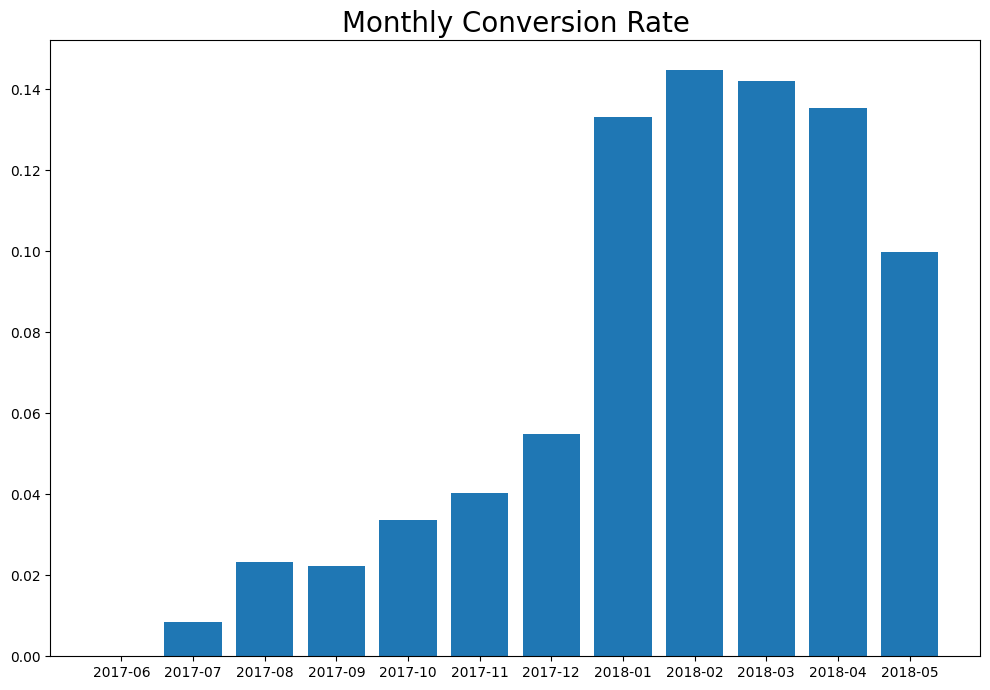

In [7]:
plt.figure(figsize=(12, 8))
plt.bar(month_conversion['list'], month_conversion['conversion_rate'])
plt.title('Monthly Conversion Rate', size=20)
plt.show()

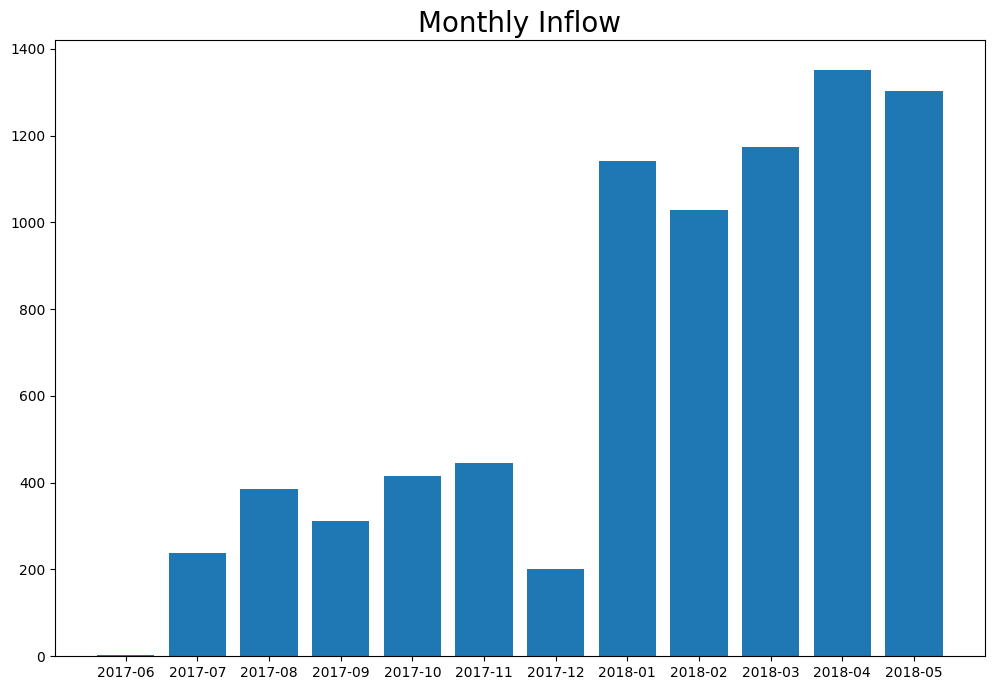

In [8]:
plt.figure(figsize=(12, 8))
plt.bar(month_conversion['list'], month_conversion['entrance'])
plt.title('Monthly Inflow', size=20)
plt.show()

### 상관분석



In [9]:
### 각 채널별 전환기간-첫유입일 상관계수
corr_analyst = marketing_channel[['origin', 'transaction_date', 'first_contact_month']]
corr_analyst['first_contact_month'] = corr_analyst['first_contact_month'].apply(lambda x : int(x.replace('-','')))
corr_analyst = corr_analyst.query('transaction_date != -100')
corr = []
for v in corr_analyst['origin'].unique().tolist() :
    ch_corr = corr_analyst.query(f'origin == "{v}"')
    a = str(v)
    b = np.corrcoef(ch_corr['first_contact_month'], ch_corr['transaction_date'])[0,1]
    corr.append([a, b])
corr = pd.DataFrame(corr, columns = ['channel', 'tran-month_corr'])
corr.sort_values(by='tran-month_corr')

,channel,tran-month_corr
0,unknown,-0.809741
4,email,-0.658007
1,paid_search,-0.610793
2,social,-0.594537
3,organic_search,-0.523838
6,direct_traffic,-0.507014
7,other_publicities,-0.500000
8,referral,-0.025965
5,display,0.359436
9,other,0.420033


In [10]:
### 일자 - 유입 상관계수
inflow_corr = marketing_channel.groupby('first_contact_date')['mql_id'].count()
inflow_corr = pd.DataFrame(inflow_corr).reset_index()
inflow_corr['first_contact_date'] = inflow_corr['first_contact_date'].apply(lambda x : int(str(x)[:8].replace('-','')))
print('inflow corrcoef')
print(np.corrcoef(inflow_corr['first_contact_date'], inflow_corr['mql_id'])[0, 1])

inflow corrcoef
0.7548503639375086


In [11]:
### 2018년도 일자 - 유입 상관계수
inflow_corr_2018 = marketing_channel.query('first_contact_year == "2018"')
inflow_corr_2018 = inflow_corr_2018.groupby('first_contact_date')['mql_id'].count()
inflow_corr_2018 = pd.DataFrame(inflow_corr_2018).reset_index()
# first_contact_date column이 "연-월-일 시:분:초" 형태이기 때문에 '연월시' 형태로 변경
inflow_corr_2018['first_contact_date'] = inflow_corr_2018['first_contact_date'].apply(lambda x : int(str(x)[:8].replace('-','')))
print('2018 inflow corrcoef')
print(np.corrcoef(inflow_corr_2018['first_contact_date'], inflow_corr_2018['mql_id'])[0, 1])

2018 inflow corrcoef
0.1522482848710088


In [12]:
### 2018년 각 채널별 첫유입일-유입수 상관계수
marketing_channel_2018 = marketing_channel.query('first_contact_year == "2018"')
inflow_channel_corr_2018 = marketing_channel_2018.groupby(['first_contact_date', 'origin'])['mql_id'].count()
inflow_channel_corr_2018 = pd.DataFrame(inflow_channel_corr_2018).reset_index()
inflow_channel_corr_2018['first_contact_date'] = inflow_channel_corr_2018['first_contact_date'].apply(lambda x : int(str(x)[:8].replace('-','')))
corr = []
for v in inflow_channel_corr_2018['origin'].unique().tolist() :
    ch_corr = inflow_channel_corr_2018.query(f'origin == "{v}"')
    a = str(v)
    b = np.corrcoef(ch_corr['first_contact_date'], ch_corr['mql_id'])[0,1]
    corr.append([a, b])
corr = pd.DataFrame(corr, columns = ['channel', 'inflow-day_corr'])
print('2018 inflow - first_contact corrcoef')
corr.sort_values(by='inflow-day_corr')

2018 inflow - first_contact corrcoef


,channel,inflow-day_corr
6,other,-0.124647
0,direct_traffic,-0.084868
2,organic_search,-0.082432
9,other_publicities,-0.007850
1,email,0.035223
7,unknown,0.067366
4,referral,0.114802
8,display,0.207916
3,paid_search,0.252615
5,social,0.409344


### 월 마케팅 예산

In [13]:
budget = clv.cal_marketing_budget(s_date='2018-01', e_date='2018-07')
budget

,shipping_month,sales,marketing_budget
0,2018-01,67622.204,7191.3558
1,2018-02,65538.204,6762.2204
2,2018-03,82442.107,6553.8204
3,2018-04,76698.230,8244.2107
4,2018-05,86748.515,7669.8230
5,2018-06,69658.803,8674.8515
6,2018-07,64890.439,6965.8803


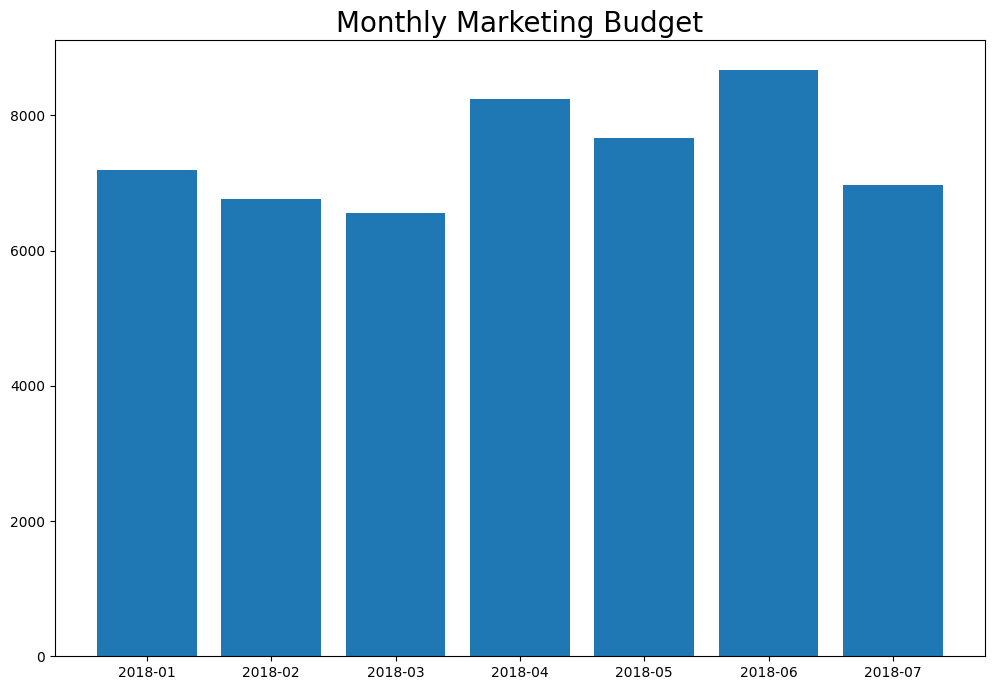

In [14]:
plt.figure(figsize=(12, 8))
plt.bar(budget['shipping_month'], budget['marketing_budget'])
plt.title('Monthly Marketing Budget', size=20)
plt.show()

## CLV(고객 생애 가치) 분석

### 셀러 분석

In [15]:
clv.cal_clv(clv_sellers)

1281.7034404016622

In [16]:
channel_data = clv.make_channel_data()
channel_data

,channel,entrance,conversion_rate,during_cv_date,median_date,min_date,max_date,clv
0,unknown,1159,0.1665,41.87,11,0,427,1773.44
1,social,1350,0.0556,60.96,30,1,371,1187.16
2,referral,284,0.0845,32.54,24,0,132,1271.97
3,paid_search,1586,0.1230,56.60,15,0,373,1132.50
4,other_publicities,65,0.0462,39.33,35,35,48,0.00
5,other,150,0.0267,15.25,13,1,42,1791.05
6,organic_search,2296,0.1180,50.00,14,-2,353,1289.25
7,email,493,0.0304,52.20,21,1,226,942.78
8,display,118,0.0508,10.33,10,0,25,92.30
9,direct_traffic,499,0.1122,31.12,10,0,306,512.38


In [27]:
natural_channel = channel_data.query('channel == "unknown" or channel == "other" or\
                                      channel == "organic_search" or channel == "direct_traffic"')
paid_channel = channel_data.drop(index = natural_channel.index)
natural_channel = natural_channel.reset_index(drop=True)
paid_channel = paid_channel.reset_index(drop=True)
paid_channel

,channel,entrance,conversion_rate,during_cv_date,median_date,min_date,max_date,clv
0,social,1350,0.0556,60.96,30,1,371,1187.16
1,referral,284,0.0845,32.54,24,0,132,1271.97
2,paid_search,1586,0.1230,56.60,15,0,373,1132.50
3,other_publicities,65,0.0462,39.33,35,35,48,0.00
4,email,493,0.0304,52.20,21,1,226,942.78
5,display,118,0.0508,10.33,10,0,25,92.30


In [30]:
print('Paid Marketing Channel')
print('inflow-clv corrcoef')
print(np.corrcoef(paid_channel['entrance'], paid_channel['clv'])[0, 1])
print('\ncvr-clv corrcoef')
print(np.corrcoef(paid_channel['conversion_rate'], paid_channel['clv'])[0, 1])

print('\n\nNatural Marketing Channel')
print('inflow-clv corrcoef')
print(np.corrcoef(natural_channel['entrance'], natural_channel['clv'])[0, 1])
print('\ncvr-clv corrcoef')
print(np.corrcoef(natural_channel['conversion_rate'], natural_channel['clv'])[0, 1])

Paid Marketing Channel
inflow-clv corrcoef
0.6559322082494443

cvr-clv corrcoef
0.4704193165344565


Natural Marketing Channel
inflow-clv corrcoef
0.02014757865382556

cvr-clv corrcoef
-0.1461989753402793


In [32]:
paid_channel['category'] = 'paid'
natural_channel['category'] = 'natural'
channel__ = pd.concat([paid_channel, natural_channel])
channel__.to_csv('marketing_channel.csv')

### 채널별 고객 획득 비용

***CASE 1. 마케팅 비용을 모든 채널에 동일하게 배분한 경우***  
***CASE 2. 마케팅 비용을 채널별 유입에 따라 배분한 경우***  


In [18]:
# 4월 마케팅 채널별 유입 수
marketing_channel_04 = marketing_channel.query('first_contact_month == "2018-04"')
marketing_channel_04 = marketing_channel_04.groupby('origin')['mql_id'].count()
marketing_channel_04

origin
direct_traffic        75
display               19
email                 50
organic_search       349
other                 26
other_publicities     12
paid_search          272
referral              45
social               325
unknown              179
Name: mql_id, dtype: int64

In [37]:
# 5월 마케팅 예산
budget_201805 = budget.query('shipping_month == "2018-05"')['marketing_budget'].tolist()

# 무료 마케팅 채널
natural_channel = ['direct_traffic', 'organic_search', 
                   'other', 'unknown']

# 마케팅 예산 배분 방식에 따른 고객 획득 비용 확인을 위한 데이터 프레임 생성
marketing_channel_05 = marketing_channel.query('first_contact_month == "2018-05"')
marketing_channel_05 = marketing_channel_05.groupby('origin')['seller_id', 'mql_id'].count()
marketing_channel_05['mql_id'] = marketing_channel_04
marketing_channel_05 = marketing_channel_05.drop(index = natural_channel)
marketing_channel_05 = pd.DataFrame(marketing_channel_05).reset_index()
marketing_channel_05['mql_id_rate'] = marketing_channel_05['mql_id'] / sum(marketing_channel_05['mql_id'])

# 마케팅 예산을 동일하게 나눌 때의 고객 획득 비용
marketing_channel_05['cac_mean'] = 0 
marketing_channel_05['mean_budget'] = budget_201805[0]/marketing_channel_05.shape[0]

# 마케팅 예산을 유입에 따라 다르게 나눌 때의 고객 획득 비용
marketing_channel_05['cac_rate'] = 0
marketing_channel_05['rate_budget'] = 0
for i in range(marketing_channel_05.shape[0]) :
    marketing_channel_05['rate_budget'][i] = budget_201805[0] * marketing_channel_05['mql_id_rate'][i]
    if marketing_channel_05['seller_id'][i] :
       marketing_channel_05['cac_mean'][i] = marketing_channel_05['mean_budget'][i] / marketing_channel_05['seller_id'][i]
       marketing_channel_05['cac_rate'][i] = (budget_201805[0] * marketing_channel_05['mql_id_rate'][i]) / marketing_channel_05['seller_id'][i]
marketing_channel_05 = marketing_channel_05.rename(columns = {'origin' : 'channel'})
marketing_channel_05 = pd.merge(marketing_channel_05, channel_data, on = 'channel')
marketing_channel_05

,channel,seller_id,mql_id,mql_id_rate,cac_mean,mean_budget,cac_rate,rate_budget,entrance,conversion_rate,during_cv_date,median_date,min_date,max_date,clv
0,display,1,19,0.026279,1278.303833,1278.303833,201.558281,201.558281,118,0.0508,10.33,10,0,25,92.30
1,email,2,50,0.069156,639.151917,1278.303833,265.208264,530.416528,493,0.0304,52.20,21,1,226,942.78
2,other_publicities,0,12,0.016598,0.000000,1278.303833,0.000000,127.299967,65,0.0462,39.33,35,35,48,0.00
3,paid_search,30,272,0.376210,42.610128,1278.303833,96.182197,2885.465914,1586,0.1230,56.60,15,0,373,1132.50
4,referral,8,45,0.062241,159.787979,1278.303833,59.671859,477.374876,284,0.0845,32.54,24,0,132,1271.97
5,social,11,325,0.449516,116.209439,1278.303833,313.427949,3447.707434,1350,0.0556,60.96,30,1,371,1187.16


In [38]:
# 마케팅 예산 책정 방식에 따른 총 고객 획득 비용의 차이
## 왼쪽 - 마케팅 예산을 동일하게 나눌 때의 고객 획득 비용
## 오른쪽 - # 마케팅 예산을 유입에 따라 다르게 나눌 때의 고객 획득 비용
sum(marketing_channel_05['cac_mean']), sum(marketing_channel_05['cac_rate'])

(2236.0632963383837, 936.0485501058301)

In [39]:
budget.to_csv('/content/drive/MyDrive/kaggle/marketing_budget.csv')
marketing_channel_05.to_csv('/content/drive/MyDrive/kaggle/marketing_channel_05.csv')

6월의 마케팅 예산 책정

In [42]:
clv.cal_recent_marketing_channel_budget()

,origin,budget
5,social,3899.48
3,paid_search,3263.57
1,email,599.92
4,referral,539.93
0,display,227.97
2,other_publicities,143.98
